# Imports and System Check

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Add, Input, Dense, Reshape, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, BatchNormalization
from keras.engine.topology import Layer, InputSpec
import os
import random
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn import metrics
from keras.utils.vis_utils import plot_model
import pickle

from sklearn import manifold
import matplotlib.colors as mcolors
color_set = mcolors.TABLEAU_COLORS
cnames = list(color_set.keys())

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Mon May 11 05:59:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    12W /  70W |     11MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Model Setup

In [4]:
# task = "MNIST"
task = "SETI_Narrow_Band"

## Residual Block and Clustering Layer Definition

In [5]:
def res_conv_block(inp, units, num_layers, activ="relu"):
    x = inp
    for i in range(num_layers):
        x = Conv2D(units, (3, 3), activation=activ, padding="same")(x)
    return Add()([x, inp])

def res_deconv_block(inp, units, num_layers, activ="relu"):
    x = inp
    for i in range(num_layers):
        x = Conv2DTranspose(units, (3, 3), activation=activ, padding="same")(x)
    return Add()([x, inp])

In [6]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

## Model Definition (SETI Narrow Band)

In [7]:
if task == "SETI_Narrow_Band":
    n_clusters = 32

    input_img = Input(shape=(16, 200, 1))
    x = res_conv_block(input_img, 64, 2)

    pool_1 = MaxPooling2D((1, 2), padding="same")(x)
    x = res_conv_block(pool_1, 64, 2)

    pool_2 = MaxPooling2D((2, 2), padding="same")(x)
    x = res_conv_block(pool_2, 64, 2)

    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2), padding="same")(x)


    flat = Flatten()(x)
    x = Dense(256, activation='relu')(flat)
    encoded = Dense(64, activation='relu', name="encoded")(x)
    x = Dense(256, activation='relu')(encoded)
    x = Dense(800, activation='relu')(x)
    x = Reshape((4, 25, 8))(x)

    x = UpSampling2D((2, 2))(x)
    up_1 = Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)

    x = res_deconv_block(up_1, 64, 2)
    up_2 = UpSampling2D((2, 2))(x)

    x = res_deconv_block(up_2, 64, 2)
    up_3 = UpSampling2D((1, 2))(x)

    x = res_deconv_block(up_3, 64, 2)
    decoded = Conv2DTranspose(1, (3, 3), padding="same", name="decoded")(x)

    autoencoder, encoder = Model(inputs=input_img, outputs=decoded, name="autoencoder"), Model(inputs=input_img, outputs=encoded, name="encoder")
    clustering_layer = ClusteringLayer(n_clusters, name='clustering_layer')(encoder.output)
    idec = Model(inputs=autoencoder.input, outputs=[clustering_layer, decoded])

In [ ]:
if task == "SETI_Narrow_Band":
    n_clusters = 10

    input_img = Input(shape=(16, 200, 1))
    x = Flatten()(input_img)
    x = Dense(1024, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(2048, activation="relu")(x)
    encoded = Dense(20, activation='relu', name="encoded",
                    activity_regularizer=None)(x)
    x = Dense(2048, activation="relu")(encoded)
    x = Dense(1024, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(3200, activation="relu")(x)
    decoded = Reshape(shape=(16, 200, 1), name="decoded")(x)
    
    autoencoder, encoder = Model(inputs=input_img, outputs=decoded, name="autoencoder"), Model(inputs=input_img, outputs=encoded, name="encoder")
    clustering_layer = ClusteringLayer(n_clusters, name='clustering_layer')(encoder.output)
    idec = Model(inputs=autoencoder.input, outputs=[clustering_layer, decoded], name="orig-idec")
    

## Model Definition (MNIST)

In [ ]:
if task == "MNIST":
    n_clusters = 10

    input_img = Input(shape=(28, 28, 1))
    x = res_conv_block(input_img, 32, 2)

    pool_1 = MaxPooling2D((2, 2), padding="same")(x)
#     pool_1 = x
    x = res_conv_block(pool_1, 32, 2)

    pool_2 = MaxPooling2D((2, 2), padding="same")(x)
    x = res_conv_block(pool_2, 32, 2)

    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)


    flat = Flatten()(x)
    x = Dense(1024, activation='relu')(flat)
    encoded = Dense(20, activation='relu', name="encoded",
                    activity_regularizer=None)(x)
    x = Dense(1024, activation='relu')(encoded)
    x = Dense(49*8, activation='relu')(x)
    x = Reshape((7, 7, 8))(x)
#     x = Dense(49*4, activation='relu')(x)
#     x = Reshape((14, 14, 1))(x)
    

    up_1 = Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(x)

    x = res_deconv_block(up_1, 32, 2)
    up_2 = UpSampling2D((2, 2))(x)

    x = res_deconv_block(up_2, 32, 2)
    up_3 = UpSampling2D((2, 2))(x)
#     up_3 = x

    x = res_deconv_block(up_3, 32, 2)
    decoded = Conv2DTranspose(1, (3, 3), padding="same", name="decoded")(x)

    autoencoder, encoder = Model(inputs=input_img, outputs=decoded, name="autoencoder"), Model(inputs=input_img, outputs=encoded, name="encoder")
    clustering_layer = ClusteringLayer(n_clusters, name='clustering_layer')(encoder.output)
    idec = Model(inputs=autoencoder.input, outputs=[clustering_layer, decoded], name="res-idec")

In [ ]:
if task == "MNIST":
    n_clusters = 10

    input_img = Input(shape=(28, 28, 1))
    x = Flatten()(input_img)
    x = Dense(500, activation="relu")(x)
    x = Dense(500, activation="relu")(x)
    x = Dense(2000, activation="relu")(x)
    encoded = Dense(10, activation='relu', name="encoded",
                    activity_regularizer=None)(x)
    x = Dense(2000, activation="relu")(encoded)
    x = Dense(500, activation="relu")(x)
    x = Dense(500, activation="relu")(x)
    x = Dense(784, activation="relu")(x)
    decoded = Reshape((28, 28, 1), name="decoded")(x)
    
    autoencoder, encoder = Model(inputs=input_img, outputs=decoded, name="autoencoder"), Model(inputs=input_img, outputs=encoded, name="encoder")
    clustering_layer = ClusteringLayer(n_clusters, name='clustering_layer')(encoder.output)
    idec = Model(inputs=autoencoder.input, outputs=[clustering_layer, decoded], name="orig-idec")
    

In [8]:
idec.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 200, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 200, 64)  640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 200, 64)  36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 16, 200, 64)  0           conv2d_2[0][0]                   
                                                                 input_1[0][0]              

# Data Preparation

## Data Sampling and Generator Construction (SETI Narrow Band)

In [9]:
dir_names = list(filter(lambda x: x.endswith("fine"), os.listdir("../../data/S-band-high")))
random.shuffle(dir_names)
dir_names, val_dir_names = dir_names[:-2], dir_names[-2:]
dir_names, val_dir_names

(['GBT_58210_37805_HIP103730_fine',
  'GBT_58307_26947_J1935+1616_fine',
  'GBT_58014_69579_HIP77629_fine',
  'GBT_58210_40853_HIP106147_fine',
  'GBT_58452_79191_HIP115687_fine',
  'GBT_58210_39862_HIP105504_fine',
  'GBT_58010_50176_HIP61317_fine',
  'GBT_58110_60123_HIP91926_fine'],
 ['GBT_58202_60970_B0329+54_fine', 'GBT_58210_41185_HIP105761_fine'])

Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [01:39<00:00,  2.20it/s]


Found 66973 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 76.20it/s]


Found 82137 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 77098 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 76.50it/s]


Found 76978 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 65335 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 48751 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 49798 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 74.04it/s]


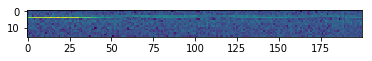

In [10]:
if task == "SETI_Narrow_Band":
    sampgen = ImageDataGenerator(
        preprocessing_function=np.log)

    num_batch_each = 200
    x_samp = np.empty((len(dir_names) * num_batch_each*32, 16, 200, 1))
    for shift, directory in enumerate(dir_names):
        gen = sampgen.flow_from_directory(
            directory=f"../../data/S-band-high/{directory}/filtered",
            target_size=(16, 200),
            color_mode="grayscale",
            class_mode="input"
        )
        for i in tqdm(range(200)):
            x_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = gen.next()[0]

    plt.imshow(x_samp[16, :, :, 0])

In [11]:
if task == "SETI_Narrow_Band":
    datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        preprocessing_function=np.log)
    datagen.fit(x_samp)
    del x_samp

In [ ]:
if task == "MNIST":
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)

# Model Training

## Autoencoder Training / Pre-Training

In [ ]:
if task == "SETI_Narrow_Band":
    print(" Start Autoencoder Training ".center(60, "-"), end="\n\n")
    autoencoder.compile("adam", loss="mse")
    histories = defaultdict(list)

    for i in range(5):
        print(f" Training Iteration {i} ".center(60, "-"), end="\n\n")
        for dir_name in dir_names:
            print(f"Training on {dir_name}")
            training_history = autoencoder.fit_generator(generator=datagen.flow_from_directory(
                directory=f"../../data/S-band-high/{dir_name}/filtered",
                target_size=(16, 200),
                color_mode="grayscale",
                class_mode="input"
            ), epochs=2)
            histories[dir_name].append(training_history)

In [ ]:
if task == "MNIST":
    print(" Start Autoencoder Training ".center(60, "-"), end="\n\n")
    autoencoder.compile("adam", loss="mse")

    for i in range(40):
        print(f" Training Iteration {i} ".center(60, "-"), end="\n\n")
        autoencoder.fit(x_train, x_train)

In [ ]:
# save model
model_name = f"{task}_res_idec_autoencoder"
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%y-%H:%M")
print("timestamp =", timestamp)

# serialize model to JSON
model_json = autoencoder.to_json()
with open(f"models/{task}/{model_name}-{timestamp}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights(f"models/{task}/{model_name}-{timestamp}.h5")

In [ ]:
# autoencoder.load_weights(f"models/res_idec_autoencoder-best.h5")

In [ ]:
if task == "SETI_Narrow_Band":
    num_batch_each = 200
    x_train = np.empty((num_batch_each*len(dir_names)*32, 16, 200, 1))
    y_train = np.empty((num_batch_each*len(dir_names)*32))
    for shift, directory in enumerate(dir_names):
        gen = datagen.flow_from_directory(
            directory=f"../../data/S-band-high/{directory}/filtered",
            target_size=(16, 200),
            color_mode="grayscale",
            class_mode="sparse"
        )
        for i in tqdm(range(num_batch_each)):
            temp_x, temp_y = gen.next()
            x_train[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_x
            y_train[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_y
    kmeans = KMeans(n_clusters)
    y_pred = kmeans.fit_predict(encoder.predict(x_train))

In [ ]:
pre_cluster_encoded = encoder.predict(x_train)

In [ ]:
tsne = manifold.TSNE(n_components=2, init='random', perplexity=20, n_jobs=-1, verbose=1)
embedded_samp = tsne.fit_transform(pre_cluster_encoded)

In [ ]:
embedded_x, embedded_y = np.split(embedded_samp, 2, axis=1)
if task == "MNIST":
    plt.scatter(embedded_x, embedded_y, c=[cnames[e] for e in y_train], marker="x")
else:
    plt.scatter(embedded_x[y_pred < 10], embedded_y[y_pred < 10], c=[cnames[e] for e in y_pred[y_pred < 10]], marker="x")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

In [ ]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

def fit_cluster(model, x, y=None, x_test=None, gamma=0.01, maxiter=500, batch_size=128, tol=1e-3, update_interval=100, model_name="res-idec", cold_start=False):
    stats = {"acc": [], "nmi":[], "ari": [], "mhp": []}
    if cold_start:
        model.compile(loss={'clustering_layer': 'kld', 'decoded': 'mse'},
                        loss_weights={'clustering_layer': gamma, 'decoded': 1},
                        optimizer="adam")
        print(' Initializing cluster centers with k-means '.center(60, "-"), end="\n\n")
        kmeans = KMeans(n_clusters)
        y_pred = kmeans.fit_predict(encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        model.get_layer(name='clustering_layer').set_weights([kmeans.cluster_centers_])
        print(" Model Compiled and Initialized ".center(60, "-"), end="\n\n")
    else:
        q, _ = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p
        y_pred_last = q.argmax(1)
        y_pred = None
    
    index = 0
    index_array = np.arange(x.shape[0])
    
    for ite in range(int(maxiter)):
        if ite % update_interval == 0:
            q, _ = model.predict(x, verbose=0)
            p = target_distribution(q)  # update the auxiliary target distribution p
            y_pred = q.argmax(1)
            delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
            y_pred_last = np.copy(y_pred)
            
            if y is not None:
                acc = np.round(cluster_acc(y, y_pred), 5)
                nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
                ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
                stats["acc"].append(acc)
                stats["nmi"].append(nmi)
                stats["ari"].append(ari)
            if x_test is not None:
                probs, _ = model.predict(x_test)
                max_probs = probs.max(1)
                stats["mhp"].append(np.round(np.mean(max_probs), 5))
            print()
            for k, v in stats.items():
                if v:
                    print(f"{k}: {v[-1]}", end=" ")
            print()
            
            if ite > 0 and delta_label < tol:
                    print(f"delta_label {delta_label} < {tol}")
                    print('Reached tolerance threshold. Stopping training.'.center(60, "-"), end="\n\n")
                    break
                    
        idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
        total_loss, clustering_loss, reconstruction_loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
        print(f"\rIteration {ite:>5}, Total Loss: {total_loss:.5f}, Cluster Loss: {clustering_loss:.5f}, Reconstruction Loss {reconstruction_loss:.5f}", end="", flush=True)
        if ite % update_interval == 0:
            print()
            
    print()
    print(" Saving Model ".center(60, "-"), end="\n\n")
    from datetime import datetime
    timestamp = datetime.now().strftime("%d-%m-%y-%H:%M")
    print("timestamp =", timestamp)

    # serialize model to JSON
    model_json = model.to_json()
    with open(f"models/{task}/{model_name}-{timestamp}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"models/{task}/{model_name}-{timestamp}.h5")
    print("Saved model to disk")
    
    return y_pred, stats

In [ ]:
model_name = "res_idec"

In [26]:
if task == "SETI_Narrow_Band":
    num_batch_each = 200
    x_cluster_samp = np.empty((num_batch_each*len(dir_names)*32, 16, 200, 1))
    y_cluster_samp = np.empty((num_batch_each*len(dir_names)*32))
    for shift, directory in enumerate(dir_names):
        gen = datagen.flow_from_directory(
            directory=f"../../data/S-band-high/{directory}/filtered",
            target_size=(16, 200),
            color_mode="grayscale",
            class_mode="sparse"
        )
        for i in tqdm(range(num_batch_each)):
            temp_x, temp_y = gen.next()
            x_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_x
            y_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_y

Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [01:32<00:00,  2.18it/s]


Found 66973 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 70.73it/s]


Found 82137 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 71.85it/s]


Found 77098 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 73.22it/s]


Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 72.37it/s]


Found 65335 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 48751 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 49798 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 71.16it/s]


In [22]:
if task == "SETI_Narrow_Band":
    num_batch_each = 200
    x_cluster_validation = np.empty((num_batch_each*len(val_dir_names)*32, 16, 200, 1))
    y_cluster_validation = np.empty((num_batch_each*len(val_dir_names)*32))
    for shift, directory in enumerate(val_dir_names):
        gen = datagen.flow_from_directory(
            directory=f"../../data/S-band-high/{directory}/filtered",
            target_size=(16, 200),
            color_mode="grayscale",
            class_mode="sparse"
        )
        for i in tqdm(range(num_batch_each)):
            temp_x, temp_y = gen.next()
            x_cluster_validation[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_x
            y_cluster_validation[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_y

Found 48472 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 69.24it/s]


Found 68430 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 71.54it/s]


In [ ]:
if task == "SETI_Narrow_Band":
    print(" Start Joint Training ".center(60, "-"), end="\n\n")
    stats = {"acc": [], "nmi":[], "ari": [], "mhp": []}
    preds, stat = fit_cluster(idec, x_cluster_samp, y_cluster_samp, x_cluster_validation, model_name=model_name, cold_start=True)
    for k, v in stat.items():
        stats[k].extend(v)
    for i in range(4):
        num_batch_each = 200
        x_cluster_samp = np.empty((num_batch_each*len(dir_names)*32, 16, 200, 1))
        y_cluster_samp = np.empty((num_batch_each*len(dir_names)*32))
        for shift, directory in enumerate(dir_names):
            gen = datagen.flow_from_directory(
                directory=f"../../data/S-band-high/{directory}/filtered",
                target_size=(16, 200),
                color_mode="grayscale",
                class_mode="sparse"
            )
            for i in tqdm(range(num_batch_each)):
                temp_x, temp_y = gen.next()
                x_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_x
                y_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_y

        preds, stat = fit_cluster(idec, x_cluster_samp, y_cluster_samp, x_cluster_validation, model_name=model_name)
        for k, v in stat.items():
            stats[k].extend(v)
            

In [ ]:
if task == "MNIST":
    rand_inds = np.random.choice(np.arange(60000), 1200*128)
    stats = {"acc": [], "nmi":[], "ari": [], "mhp": []}
    print(" Start Joint Training ".center(60, "-"), end="\n\n")
    preds, stat = fit_cluster(idec, x_train[rand_inds], y_train[rand_inds], x_test, model_name=model_name, cold_start=True)
    for k, v in stat.items():
        stats[k].extend(v)
    for i in range(4):
        rand_inds = np.random.choice(np.arange(60000), 600*128)
        preds, stat = fit_cluster(idec, x_train[rand_inds], y_train[rand_inds], x_test, model_name=model_name)
        for k, v in stat.items():
            stats[k].extend(v)

In [ ]:
cluster_encoded = encoder.predict(x_train)
probs, _ = idec.predict(x_train)
y_pred = probs.argmax(1)
tsne = manifold.TSNE(n_components=2, init='random', perplexity=5, n_jobs=-1, verbose=1)
embedded_samp = tsne.fit_transform(cluster_encoded)

In [ ]:
if task == "SETI_Narrow_Band":
    threshold = 0.2
    print(np.count_nonzero(np.max(probs, axis=1) > threshold))
    embedded_samp_save = embedded_samp.copy()

In [ ]:
if task == "SETI_Narrow_Band":
    y_pred = np.argmax(probs, axis=1)
    counts = [(i, np.count_nonzero(y_pred[np.max(probs, axis=1) > threshold] == i)) for i in range(32)]
    counts.sort(key=lambda x: x[1], reverse=True)
    plt_clusters = counts[:10]
    chosen_inds = np.zeros(y_pred.shape)
    for c in plt_clusters:
        chosen_inds += (y_pred == c[0])
    embedded_samp = embedded_samp_save[chosen_inds == 1]
    y_train = y_pred[chosen_inds == 1]
    for i, c in enumerate(plt_clusters):
        y_train[y_train==c[0]] = i

In [ ]:
embedded_x, embedded_y = np.split(embedded_samp, 2, axis=1)
plt.scatter(embedded_x, embedded_y, c=[cnames[e] for e in y_train], marker="x")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

In [ ]:
embedded_x, embedded_y = np.split(embedded_samp, 2, axis=1)
plt.scatter(embedded_x, embedded_y, c=[cnames[e] for e in y_pred], marker="x")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

In [ ]:
if task == "MNIST":
    for i in range(5):
        rand_inds = np.random.choice(np.arange(60000), 600*128)
        preds, stat = fit_cluster(idec, x_train[rand_inds], y_train[rand_inds], x_test, model_name=model_name)
        for k, v in stat.items():
            stats[k].extend(v)

In [ ]:
if task == "SETI_Narrow_Band":
    print(" Start Joint Training ".center(60, "-"), end="\n\n")
    for i in range(5):
        num_batch_each = 200
        x_cluster_samp = np.empty((num_batch_each*len(dir_names)*32, 16, 200, 1))
        y_cluster_samp = np.empty((num_batch_each*len(dir_names)*32))
        for shift, directory in enumerate(dir_names):
            gen = datagen.flow_from_directory(
                directory=f"../../data/S-band-high/{directory}/filtered",
                target_size=(16, 200),
                color_mode="grayscale",
                class_mode="sparse"
            )
            for i in tqdm(range(num_batch_each)):
                temp_x, temp_y = gen.next()
                x_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_x
                y_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_y

        preds, stat = fit_cluster(idec, x_cluster_samp, y_cluster_samp, x_cluster_validation, model_name=model_name)
        for k, v in stat.items():
            stats[k].extend(v)
            

In [ ]:
cluster_encoded = encoder.predict(x_train)
probs, _ = idec.predict(x_train)
y_pred = probs.argmax(1)
tsne = manifold.TSNE(n_components=2, init='random', perplexity=40, n_jobs=-1, verbose=0)
embedded_samp = tsne.fit_transform(cluster_encoded)

In [ ]:
embedded_x, embedded_y = np.split(embedded_samp, 2, axis=1)
plt.scatter(embedded_x, embedded_y, c=[cnames[e] for e in y_train], marker="x")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

In [ ]:
import pickle

In [ ]:
with open(f"{model_name}_stats.pkl", "wb") as f:
    pickle.dump(stats, f)

In [12]:
stats = pickle.load(open("res_idec_stats_last.pkl", "rb"))

In [13]:
stats_orig = pickle.load(open("idec_orig_stats.pkl", "rb"))

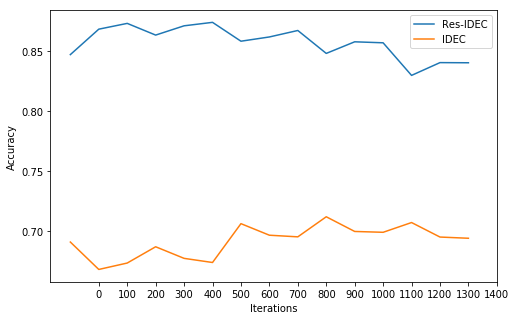

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(stats["acc"][1:16], label="Res-IDEC")
plt.plot(stats_orig["acc"][1:16], label="IDEC")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, 16), np.arange(0, 1500, 100))
plt.legend()

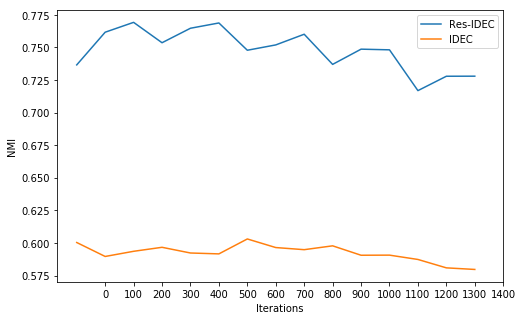

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(stats["nmi"][1:16], label="Res-IDEC")
plt.plot(stats_orig["nmi"][1:16], label="IDEC")
plt.xlabel("Iterations")
plt.ylabel("NMI")
plt.xticks(np.arange(1, 16), np.arange(0, 1500, 100))
plt.legend()

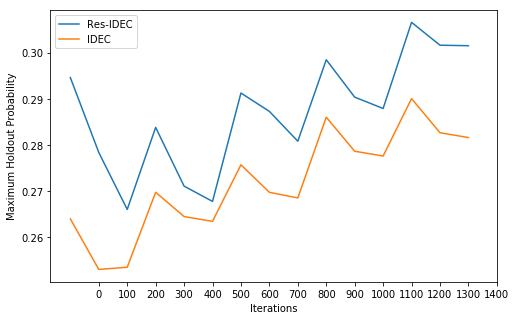

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(stats["mhp"][1:16], label="Res-IDEC")
plt.plot(stats_orig["mhp"][1:16], label="IDEC")
plt.xlabel("Iterations")
plt.ylabel("Maximum Holdout Probability")
plt.xticks(np.arange(1, 16), np.arange(0, 1500, 100))
plt.legend()

In [17]:
max(stats["acc"]), max(stats["nmi"]), max(stats["mhp"])

(0.87423, 0.76927, 0.30657)

In [18]:
max(stats_orig["acc"]), max(stats_orig["nmi"]), max(stats_orig["mhp"])

(0.76365, 0.63439, 0.35544)

In [19]:
idec.load_weights(f"models/{task}/res_idec-10-05-20-22:13.h5")

In [27]:
probs, recons = idec.predict(x_cluster_samp, verbose=0)

In [28]:
probs_val, recons_val = idec.predict(x_cluster_validation, verbose=0)

In [29]:
probs.shape, probs_val.shape

((51200, 32), (12800, 32))

In [30]:
max_probs = np.max(probs, axis=1)
max_probs_val = np.max(probs_val, axis=1)

In [31]:
np.mean(max_probs), np.mean(max_probs_val)

(0.23382162, 0.24136993)

[2.208 2.155 1.138 4.422 1.581 4.168 3.324 1.75  0.757 3.645 4.324 1.539
 1.066 5.508 3.103 2.271 1.658 9.259 3.    4.835 4.426 3.521 1.97  5.624
 5.712 4.936 2.695 0.891 1.404 4.027 1.483 1.601]


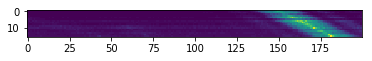

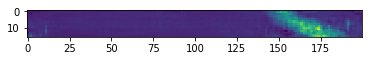

In [134]:
i = 8
np.set_printoptions(precision=3, suppress=True)
plt.figure()
plt.imshow(x_cluster_samp[i, :, :, 0])
plt.figure()
plt.imshow(recons[i, :, :, 0])
print(probs[i]*100)

In [ ]:
# Save Model
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%y-%H:%M")
print("timestamp =", timestamp)

model_name = "cluster_model_64"
# serialize model to JSON
model_json = autoencoder.to_json()
with open(f"models/{model_name}-{timestamp}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights(f"models/{model_name}-{timestamp}.h5")
print("Saved model to disk")

In [ ]:
# Load Model
with open("models/cluster_model-16-04-20-15:46.json") as file:
    loaded_model_json = file.read()
autoencoder = keras.models.model_from_json(loaded_model_json)
autoencoder.load_weights("models/cluster_model-16-04-20-15:46.h5")
print("loaded model")

In [ ]:
num_batch_each = 200
x_cluster_samp = np.empty((num_batch_each*len(dir_names)*32, 16, 200, 1))
y_cluster_samp = np.empty((num_batch_each*len(dir_names)*32))
for shift, directory in enumerate(dir_names):
    gen = datagen.flow_from_directory(
        directory=f"../../data/S-band/{directory}/filtered",
        target_size=(16, 200),
        color_mode="grayscale",
        class_mode="sparse"
    )
    for i in tqdm(range(num_batch_each)):
        temp_x, temp_y = gen.next()
        x_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_x
        y_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_y

In [ ]:
encoder = Model(inputs=idec.input, outputs=idec.get_layer("encoded").output)

In [ ]:
from sklearn import manifold
import matplotlib.colors as mcolors
color_set = mcolors.TABLEAU_COLORS
cnames = list(color_set.keys())

In [34]:
encoded_samp = encoder.predict(x_cluster_samp)
probs, recons = idec.predict(x_cluster_samp)

In [35]:
tsne = manifold.TSNE(n_components=2, init='random', perplexity=20, n_jobs=-1, verbose=1)
embedded_samp = tsne.fit_transform(encoded_samp)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 51200 samples in 1.469s...
[t-SNE] Computed neighbors for 51200 samples in 29.479s...
[t-SNE] Computed conditional probabilities for sample 1000 / 51200
[t-SNE] Computed conditional probabilities for sample 2000 / 51200
[t-SNE] Computed conditional probabilities for sample 3000 / 51200
[t-SNE] Computed conditional probabilities for sample 4000 / 51200
[t-SNE] Computed conditional probabilities for sample 5000 / 51200
[t-SNE] Computed conditional probabilities for sample 6000 / 51200
[t-SNE] Computed conditional probabilities for sample 7000 / 51200
[t-SNE] Computed conditional probabilities for sample 8000 / 51200
[t-SNE] Computed conditional probabilities for sample 9000 / 51200
[t-SNE] Computed conditional probabilities for sample 10000 / 51200
[t-SNE] Computed conditional probabilities for sample 11000 / 51200
[t-SNE] Computed conditional probabilities for sample 12000 / 51200
[t-SNE] Computed conditional probabilities for sa

In [37]:
threshold = 0.3
np.count_nonzero(np.max(probs, axis=1) > threshold)

12875

In [38]:
y_pred = np.argmax(probs, axis=1)
y_pred[np.max(probs, axis=1) < threshold] = -1

In [40]:
counts = [(i, np.count_nonzero(y_pred[np.max(probs, axis=1) > threshold] == i)) for i in range(32)]
counts.sort(key=lambda x: x[1], reverse=True)
plt_clusters = counts[:10]
chosen_inds = np.zeros(y_pred.shape)
for c in plt_clusters:
    chosen_inds += (y_pred == c[0])
counts

[(27, 5384),
 (8, 3894),
 (12, 2028),
 (2, 924),
 (28, 264),
 (7, 78),
 (15, 61),
 (30, 51),
 (13, 44),
 (11, 43),
 (17, 43),
 (0, 25),
 (4, 21),
 (1, 5),
 (26, 5),
 (21, 3),
 (18, 2),
 (3, 0),
 (5, 0),
 (6, 0),
 (9, 0),
 (10, 0),
 (14, 0),
 (16, 0),
 (19, 0),
 (20, 0),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (29, 0),
 (31, 0)]

In [ ]:
embedded_samp_plot = embedded_samp[(y_pred < 11) * (y_pred != -1)]
y_pred_plot = y_pred[(y_pred < 11) * (y_pred != -1)]

In [ ]:
pred_counts = {}
for class_ind in np.unique(y_pred):
    pred_counts[class_ind] = np.count_nonzero(y_pred == class_ind)
pred_counts

In [ ]:
list(enumerate(cnames))

In [ ]:
# 2D
embedded_x, embedded_y = np.split(embedded_samp_plot, 2, axis=1)
plt.scatter(embedded_x, embedded_y, c=[cnames[e] for e in y_pred_plot])

# # 3D
# fig = plt.figure()
# ax = plt.axes(projection='3d')

# embedded_x, embedded_y, embedded_z = np.split(embedded_samp, 3, axis=1)
# ax.scatter3D(embedded_x, embedded_y, embedded_z)

In [127]:
inds = np.arange(y_pred.shape[0])[y_pred == 0]

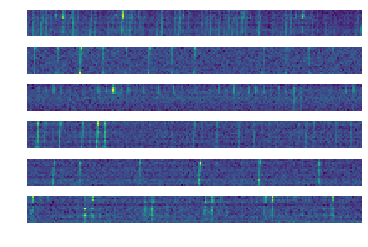

In [128]:
sample_inds = np.random.choice(inds, size=6)
figure, axes = plt.subplots(nrows=6, ncols=1)
plt.subplot(611)
plt.imshow(x_cluster_samp[sample_inds[0], :, :, 0])
plt.axis("off")
plt.subplot(612)
plt.imshow(x_cluster_samp[sample_inds[1], :, :, 0])
plt.axis("off")
plt.subplot(613)
plt.imshow(x_cluster_samp[sample_inds[2], :, :, 0])
plt.axis("off")
plt.subplot(614)
plt.imshow(x_cluster_samp[sample_inds[3], :, :, 0])
plt.axis("off")
plt.subplot(615)
plt.imshow(x_cluster_samp[sample_inds[4], :, :, 0])
plt.axis("off")
plt.subplot(616)
plt.imshow(x_cluster_samp[sample_inds[5], :, :, 0])
plt.axis("off")
figure.tight_layout(pad=3.0)

In [ ]:
import pandas as pd

In [ ]:
gen = datagen.flow_from_directory(
    directory=f"../../data/S-band/GBT_58210_37805_HIP103730_fine/filtered",
    target_size=(16, 200),
    color_mode="grayscale",
    class_mode="input",
    shuffle=False
)

In [ ]:
x_single_file_samp = np.empty((1000*32, 16, 200, 1))
filenames = []
for i in tqdm(range(1000)):
        temp_x, temp_y = gen.next()
        x_single_file_samp[(i)*32:(i+1)*32] = temp_x
        idx = (gen.batch_index - 1) * gen.batch_size
        filenames.extend(gen.filenames[idx : idx + gen.batch_size])


In [ ]:
df = pd.read_pickle("../../data/S-band/GBT_58210_37805_HIP103730_fine/info_df.pkl")
df = df.set_index("index")
df.sort_index()

In [ ]:
get_ind = lambda name: int(name.split("/")[1].split(".")[0])

In [ ]:
frequencies = np.array([df.loc[get_ind(name)]["freqs"] for name in filenames])

In [ ]:
probs, recons = idec.predict(x_single_file_samp)

In [ ]:
# check that filenames match
test_im = plt.imread(f"../../data/S-band/GBT_58210_37805_HIP103730_fine/filtered/{filenames[0]}")
plt.figure()
plt.imshow(test_im)
plt.figure()
plt.imshow(x_single_file_samp[0, :, :, 0])

In [ ]:
preds = np.argmax(probs, axis=1)
preds.shape, frequencies.shape

In [ ]:
plt_frequencies = []
for i in range(0, 11):
    if len(frequencies[preds==i]) > 0:
        plt_frequencies.append(frequencies[preds==i])

In [ ]:
len(plt_frequencies)

In [ ]:
h = plt.hist(plt_frequencies, bins=20, range=(np.min(frequencies), np.max(frequencies)))
plt.yscale("log")

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [ ]:
scaled_samp = StandardScaler().fit_transform(encoded_samp)

In [ ]:
db = DBSCAN(eps=0.5, min_samples=6).fit(scaled_samp)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

In [ ]:
print(len(labels))

In [ ]:
inds = np.where(labels==1)[0]
print(f"Number of samples: {len(inds)}")

In [ ]:
sample_inds = np.random.choice(inds, size=6)
figure, axes = plt.subplots(nrows=6, ncols=1)
plt.subplot(611)
plt.imshow(sample[sample_inds[0], :, :, 0])
plt.subplot(612)
plt.imshow(sample[sample_inds[1], :, :, 0])
plt.subplot(613)
plt.imshow(sample[sample_inds[2], :, :, 0])
plt.subplot(614)
plt.imshow(sample[sample_inds[3], :, :, 0])
plt.subplot(615)
plt.imshow(sample[sample_inds[4], :, :, 0])
plt.subplot(616)
plt.imshow(sample[sample_inds[5], :, :, 0])
figure.tight_layout(pad=3.0)